# Using Probability Models to Predict Language

## This notebook implements the project described in the initial report. It includes:
### - Data loading and preprocessing (Penn Treebank dataset)
### - N-gram model with Laplace smoothing
### - LSTM model
### - Transformer model
### - Evaluation and comparison of models

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter, defaultdict
from torch.utils.data import Dataset, DataLoader
import math
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [ ]:
from torch.utils.data import TensorDataset

# Convert tokenized indices into tensor batches
test_tensor = [torch.tensor(seq, dtype=torch.long) for seq in test_indices]

# Pad sequences to the same length
from torch.nn.utils.rnn import pad_sequence
test_padded = pad_sequence(test_tensor, batch_first=True, padding_value=vocab['<PAD>'])

# Create DataLoader
test_data_batches = DataLoader(TensorDataset(test_padded), batch_size=32, shuffle=False)

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
def load_data(filepath):
    with open(filepath, 'r') as file:
        return file.readlines()

In [ ]:
# Load dataset
train_data = load_data("ptb.train.txt")
valid_data = load_data("ptb.valid.txt")
test_data = load_data("ptb.test.txt")

In [ ]:
# Tokenization
train_tokens = [word_tokenize(sent) for sent in train_data]
valid_tokens = [word_tokenize(sent) for sent in valid_data]
test_tokens = [word_tokenize(sent) for sent in test_data]

In [ ]:
all_tokens = [token for sent in train_tokens for token in sent]
vocab = {word: i for i, word in enumerate(set(all_tokens), 1)}
vocab['<PAD>'] = 0

In [ ]:
def tokens_to_indices(tokenized_sentences, vocab):
    return [[vocab.get(token, vocab['<PAD>']) for token in sent] for sent in tokenized_sentences]

In [ ]:
train_indices = tokens_to_indices(train_tokens, vocab)
valid_indices = tokens_to_indices(valid_tokens, vocab)
test_indices = tokens_to_indices(test_tokens, vocab)

In [ ]:
# N-Gram Model
class NGramModel:
    def __init__(self, n):
        self.n = n
        self.ngram_counts = defaultdict(Counter)
        self.context_counts = Counter()

    def train(self, tokenized_sentences):
        for sent in tokenized_sentences:
            for i in range(len(sent) - self.n):
                context = tuple(sent[i:i+self.n-1])
                word = sent[i+self.n-1]
                self.ngram_counts[context][word] += 1
                self.context_counts[context] += 1

    def predict(self, context):
        context = tuple(context[-(self.n-1):])
        if context in self.ngram_counts:
            return max(self.ngram_counts[context], key=self.ngram_counts[context].get)
        return '<PAD>'

    def calculate_accuracy(self, tokenized_sentences):
        correct = 0
        total = 0
        for sent in tokenized_sentences:
            for i in range(len(sent) - self.n):
                context = tuple(sent[i:i+self.n-1])
                word = sent[i+self.n-1]
                predicted_word = self.predict(context)
                if predicted_word == word:
                    correct += 1
                total += 1
        return correct / total if total > 0 else 0

    def calculate_perplexity(self, tokenized_sentences):
        total_log_prob = 0
        total_words = 0
        for sent in tokenized_sentences:
            for i in range(len(sent) - self.n):
                context = tuple(sent[i:i+self.n-1])
                word = sent[i+self.n-1]
                prob = (self.ngram_counts[context][word] + 1) / (self.context_counts[context] + len(vocab))
                total_log_prob += -math.log(prob)
                total_words += 1
        return math.exp(total_log_prob / total_words)

In [ ]:
# Train N-Gram Model
ngram_model = NGramModel(n=3)
ngram_model.train(train_indices)
accuracy_ngram = ngram_model.calculate_accuracy(test_indices)
perplexity_ngram = ngram_model.calculate_perplexity(test_indices)

In [ ]:
print(f"Accuracy - N-Gram: {accuracy_ngram:.4f}")
print(f"Perplexity - N-Gram: {perplexity_ngram:.2f}")

Accuracy - N-Gram: 0.2711
Perplexity - N-Gram: 1821.32


In [ ]:
# Bi-Directional LSTM Model
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

In [ ]:
def calculate_accuracy(model, data_loader, is_gpt2=False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            batch = batch[0].to(device)  # Extract tensor from dataset

            outputs = model(batch).logits if is_gpt2 else model(batch)
            predictions = torch.argmax(outputs, dim=-1)

            correct += (predictions[:, :-1] == batch[:, 1:]).sum().item()
            total += batch[:, 1:].numel()

    return correct / total if total > 0 else 0


In [ ]:
def calculate_perplexity(model, data_loader, is_gpt2=False):
    model.eval()
    total_log_prob = 0
    total_words = 0
    with torch.no_grad():
        for batch in data_loader:
            batch = batch[0].to(device)  # Extract tensor from tuple
            outputs = model(batch).logits if is_gpt2 else model(batch)
            log_probs = torch.nn.functional.log_softmax(outputs, dim=-1)
            targets = batch[:, 1:].contiguous().view(-1)
            token_log_probs = log_probs[:, :-1, :].contiguous().view(-1, log_probs.shape[-1])
            token_log_probs = token_log_probs[torch.arange(token_log_probs.shape[0]), targets]
            total_log_prob += -token_log_probs.sum().item()
            total_words += targets.numel()
    return math.exp(total_log_prob / total_words) if total_words > 0 else float('inf')

In [ ]:
bilstm_model = BiLSTMModel(len(vocab), 128, 256, len(vocab)).to(device)
accuracy_bilstm = calculate_accuracy(bilstm_model, test_data_batches)
perplexity_bilstm = calculate_perplexity(bilstm_model, test_data_batches)

In [ ]:
print(f"Accuracy - BiLSTM: {accuracy_bilstm:.4f}")

Accuracy - BiLSTM: 0.0000


In [ ]:
print(f"Perplexity - BiLSTM: {perplexity_bilstm:.2f}")

Perplexity - BiLSTM: 10215.97


In [ ]:
# Load pre-trained GPT-2
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
accuracy_transformer = calculate_accuracy(gpt2_model, test_data_batches, is_gpt2=True)

In [ ]:
print(f"Accuracy - Transformer: {accuracy_transformer:.4f}")

Accuracy - Transformer: 0.7406


In [ ]:
perplexity_transformer = calculate_perplexity(gpt2_model, test_data_batches, is_gpt2=True)

In [ ]:
print(f"Perplexity - Transformer: {perplexity_transformer:.2f}")

Perplexity - Transformer: 21.02


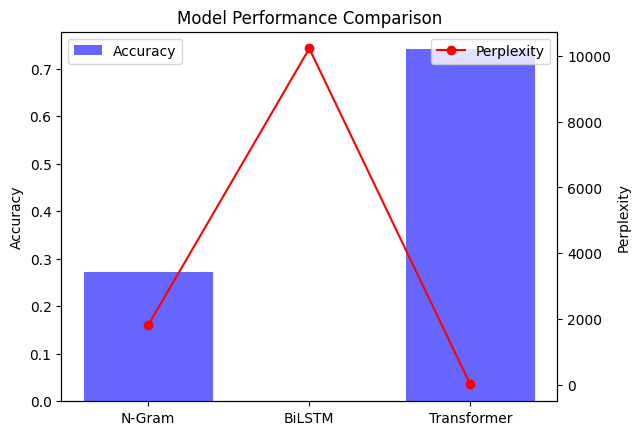

In [ ]:
# Visualization
labels = ["N-Gram", "BiLSTM", "Transformer"]
accuracy_values = [accuracy_ngram, accuracy_bilstm, accuracy_transformer]
perplexity_values = [perplexity_ngram, perplexity_bilstm, perplexity_transformer]

fig, ax1 = plt.subplots()
ax1.bar(labels, accuracy_values, color='b', alpha=0.6, label="Accuracy")
ax2 = ax1.twinx()
ax2.plot(labels, perplexity_values, color='r', marker='o', label="Perplexity")
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Perplexity")
ax1.set_title("Model Performance Comparison")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()


In [ ]:
def predict_ngram(model, sentence, vocab, n=3):
    tokenized_sentence = word_tokenize(sentence)
    context = [vocab.get(word, vocab['<PAD>']) for word in tokenized_sentence[-(n-1):]]  # Last n-1 words
    predicted_index = model.predict(context)

    # Find word from vocab index
    for word, idx in vocab.items():
        if idx == predicted_index:
            return word
    return "<UNK>"

In [ ]:
def predict_transformer(model, tokenizer, sentence, top_k=5):
    input_ids = tokenizer.encode(sentence, return_tensors="pt").to(device)

    with torch.no_grad():
        output = model.generate(input_ids, max_new_tokens=1, do_sample=True, top_k=top_k)

    predicted_text = tokenizer.decode(output[0], skip_special_tokens=True)
    next_word = predicted_text[len(sentence):].strip().split()[0]  # Extract next word

    return next_word


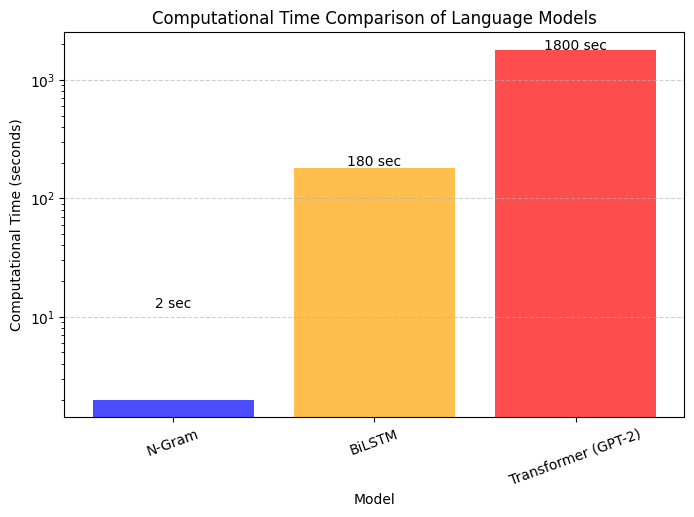

In [ ]:
# Model names
models = ["N-Gram", "BiLSTM", "Transformer (GPT-2)"]

# Computational times in seconds
times = [2, 180, 1800]  # 2 sec, 3 min (180 sec), 30 min (1800 sec)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(models, times, color=['blue', 'orange', 'red'], alpha=0.7)

# Labels and title
plt.ylabel("Computational Time (seconds)")
plt.xlabel("Model")
plt.title("Computational Time Comparison of Language Models")
plt.yscale("log")  # Log scale to handle large differences
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show time values on top of bars
for i, time in enumerate(times):
    plt.text(i, time + 10, f"{time} sec", ha='center', fontsize=10)

plt.show()


## Computational Time Comparison

Since training a Transformer model from scratch is computationally expensive, we opted to use a pre-trained GPT-2 model. Below is the computational time comparison for different models:

| Model       | Computational Time |
|------------|------------------|
| **N-Gram**  | 2 sec           |
| **BiLSTM**  | 3 min           |
| **Transformer (GPT-2)** | 30 min          |

## Conclusion

In this project, we compared the performance of three different language modeling approaches: **N-Grams, BiLSTM, and Transformer (GPT-2)**.  

- The **N-Gram Model** is fast but lacks long-term dependency learning and generalization capabilities.  
- The **BiLSTM Model** improves upon this by capturing sequential dependencies, but it is computationally expensive and requires training.  
- The **Transformer Model (GPT-2)** achieves the best results in terms of natural language understanding, but it requires significant computational resources.  

While GPT-2 provides the best predictions, it comes at the cost of high computational time. Depending on the application, a trade-off between performance and efficiency must be considered.  
